### Team: 3
### Members: Abhishek Varma, Kevin Roy, Saurabh Shete.

#**Credit Score Classification using PySpark - M2**

### Introduction

Credit score classification is a critical task in the financial industry, enabling institutions to assess the risk profile of individuals and make informed lending decisions. This project focuses on predicting a person's credit score category (e.g., good, poor and standard credit) based on a variety of financial features. Accurate credit score predictions help streamline credit approval processes, minimize defaults, and improve risk management.

**Poor Credit**: Indicates a high risk of default.

**Standard Credit**: Shows moderate creditworthiness.

**Good Credit**: Reflecting low risk and strong creditworthiness.

To achieve this, we utilize PySpark, a robust framework for large-scale data processing and machine learning. PySpark's distributed computing capabilities make it well-suited for handling large datasets efficiently. We implement and evaluate classification models, including Logistic Regression and Random Forest, to identify the most effective approach for predicting credit scores. The project emphasizes both technical implementation and the practical significance of data-driven insights in credit risk assessment.

### Dataset
The dataset used in this project is sourced from [Kaggle: Credit Score Classification](https://www.kaggle.com/datasets/parisrohan/credit-score-classification/data). The dataset includes various features related to financial behavior, such as income, debt, payment history, and more.


## Install required packages

Before we start, we need to install some required packages. These packages will help us set up the Spark environment and run the machine learning algorithms.

In [ ]:
!pip install pyspark
!pip install kagglehub

## Importing Libraries

We import the necessary libraries, which provide tools for data handling, working with various machine learning models, and evaluating the results.

In [ ]:
import kagglehub
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from itertools import chain
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Create Spark Session

In [ ]:
spark = SparkSession.builder.appName("CreditScoreClassification").getOrCreate()

## Download the Credit Score Dataset from Kaggle


In [ ]:
path = kagglehub.dataset_download("parisrohan/credit-score-classification")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1


## Loading the Credit Score Dataset

To ensure the code runs seamlessly on both Google Colab and Databricks, we have included a check that allows it to adapt to either environment without requiring manual intervention.

In [ ]:
# Import required libraries
import kagglehub
from pyspark.sql import SparkSession
import os

try:
    # Try Colab path first by checking if we're in Colab environment
    if os.path.exists("/root/.cache/kagglehub"):
        print("\nTrying to read using Colab path...")
        colab_path = "/root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1/train.csv"
        df = spark.read.csv(colab_path, header=True)
        print("Successfully loaded dataset using Colab path")
    else:
        raise Exception("Not in Colab environment")

except Exception as e:
    print(f"Not a Colab environment or Colab path failed: {str(e)}")
    try:
        # For Databricks, convert the downloaded path
        print("\nTrying to read using Databricks path...")
        # Remove 'dbfs:' if it was added automatically
        if path.startswith('dbfs:'):
            path = path[5:]
        if not path.startswith('/'):
            path = '/' + path

        databricks_path = f"file:{path}/train.csv"
        print(f"Attempting to read from: {databricks_path}")
        df = spark.read.csv(databricks_path, header=True)
        print("Successfully loaded dataset using Databricks path")

    except Exception as e2:
        print(f"Databricks path attempt failed: {str(e2)}")
        # One final attempt with direct file path
        try:
            print("\nTrying one final attempt with direct path...")
            final_path = f"{path}/train.csv"
            df = spark.read.csv(final_path, header=True)
            print("Successfully loaded dataset using direct path")
        except Exception as e3:
            raise Exception(f"""
            Failed to load dataset in both Colab and Databricks environments.
            Colab Error: {str(e)}
            Databricks Error: {str(e2)}
            Final Attempt Error: {str(e3)}
            Downloaded path was: {path}
            """)

# Verify the data was loaded correctly
print(f"\nDataset loaded successfully with {df.count():,} rows and {len(df.columns)} columns")


Trying to read using Colab path...
Successfully loaded dataset using Colab path

Dataset loaded successfully with 100,000 rows and 28 columns


In [ ]:
print("\nDataset loaded successfully!")
df.show()


Dataset loaded successfully!
+------+-----------+--------+---------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|           Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+---

# Stratified Sampling in PySpark

This code performs stratified sampling to create a balanced dataset with a target number of records per class.

1. **Target Calculation**: The target number of records per class is determined as `5000 // n_classes`.

2. **Sampling for Each Class**:
   - Iterates over class counts to compute the sampling fraction for each class as `target_per_class / class_row['count']`.
   - Ensures the sampling fraction does not exceed `1.0` to avoid oversampling.
   - Filters the dataset for each class and applies sampling using `sample(withReplacement=False)`.

3. **Combining Samples**: The sampled subsets from each class are combined using the `union()` function to form the final dataset.

4. **Result Verification**: Outputs the size of the final dataset for validation.


In [ ]:
class_counts = df.groupBy("Credit_Score").count().collect()
n_classes = len(class_counts)

In [ ]:
from pyspark.sql.functions import col, count
target_per_class = 5000 // n_classes

# Create stratified sample
sampled_dfs = []
for class_row in class_counts:
    class_label = class_row['Credit_Score']
    class_fraction = target_per_class / class_row['count']

    # Ensure we don't try to sample more than 100% of any class
    class_fraction = min(class_fraction, 1.0)

    class_sample = df.filter(col("Credit_Score") == class_label) \
                    .sample(withReplacement=False, fraction=class_fraction, seed=42)
    sampled_dfs.append(class_sample)

# Union all the sampled classes
final_df = sampled_dfs[0]
for i in range(1, len(sampled_dfs)):
    final_df = final_df.union(sampled_dfs[i])

# Verify the results
print("Final dataset size:", final_df.count())

Final dataset size: 4925


In [ ]:
df=final_df

    
# About the Dataset

This dataset provides a comprehensive view of customer profiles, encompassing demographic details, financial histories, and payment patterns that play a crucial role in evaluating credit risk. The goal is to clean and analyze this data to identify key features suitable for training Machine Learning Algorithms.

- **Dataset:** Credit Score Dataset  
- **Content:** Customer demographic, financial, and credit history data.  
- **Number of Rows:** 100,000
- **Number of Columns:** 28  

| **No** | **Inputs**                  | **Description**                                                                                  |
|-------|-----------------------------|--------------------------------------------------------------------------------------------------|
| 1     | **id**                       | Unique identifier for each record.                                                               |
| 2     | **customer_id**              | Unique identifier for each customer.                                                             |
| 3     | **month**                    | Month of the transaction or record.                                                              |
| 4     | **name**                     | Customer’s name.                                                                                 |
| 5     | **age**                      | The customer’s age.                                                                              |
| 6     | **ssn**                      | Customer’s social security number.                                                               |
| 7     | **occupation**               | The customer’s occupation.                                                                       |
| 8     | **annual_income**            | The customer’s annual income.                                                                    |
| 9     | **monthly_inhand_salary**    | The customer’s monthly take-home salary.                                                         |
| 10    | **num_bank_accounts**        | Total number of bank accounts owned by the customer.                                            |
| 11    | **num_credit_card**          | Total number of credit cards held by the customer.                                              |
| 12    | **interest_rate**            | The interest rate applied to loans or credits.                                                  |
| 13    | **num_of_loan**              | Number of loans the customer has taken.                                                          |
| 14    | **type_of_loan**             | Categories of loans obtained by the customer.                                                   |
| 15    | **delay_from_due_date**      | The delay in payment relative to the due date.                                                 |
| 16    | **num_of_delayed_payment**   | Total instances of late payments made by the customer.                                          |
| 17    | **changed_credit_limit**     | Adjustments made to the customer’s credit limit.                                               |
| 18    | **num_credit_inquiries**     | Number of inquiries made regarding the customer's credit.                                       |
| 19    | **credit_mix**               | The variety of credit types the customer uses (e.g., loans, credit cards).                     |
| 20    | **outstanding_debt**         | Total amount of debt the customer currently owes.                                              |
| 21    | **credit_utilization_ratio** | Proportion of credit used compared to the total credit limit.                                   |
| 22    | **credit_history_age**       | Duration of the customer’s credit history.                                                      |
| 23    | **payment_of_min_amount**    | Indicates if the customer pays the minimum required amount each month.                         |
| 24    | **total_emi_per_month**      | Total Equated Monthly Installment (EMI) paid by the customer.                                   |
| 25    | **amount_invested_monthly**  | Monthly investment amount made by the customer.                                                 |
| 26    | **payment_behaviour**        | Customer’s payment habits and tendencies.                                                       |
| 27    | **monthly_balance**          | The remaining balance in the customer’s account at the end of each month.                      |
| 28    | **credit_score**             | The customer’s credit score (target variable: "Good," "Poor," "Standard").                     |

## Column Groups

The dataset's columns are categorized into the following groups for preprocessing and analysis:

**1. Columns to Drop:**

These columns are deemed irrelevant or redundant for credit score prediction and will be removed from the dataset.

| Column Name             | Description                                                                   |
|--------------------------|-------------------------------------------------------------------------------|
| **ID**                     | Unique identifier (likely redundant).                                           |
| **Customer_ID**            | Unique customer identifier (likely redundant).                                  |
| **Month**                  | Month of the transaction or record (potentially irrelevant for prediction). |
| **Name**                   | Customer's name (irrelevant for prediction).                                  |
| **SSN**                    | Social Security Number (irrelevant and sensitive information).                   |
| **Type_of_Loan**           | Loan type (detailed analysis might reveal useful information, but omitted for this analysis)             |
| **Changed_Credit_Limit**  | Changes to credit limit (handled implicitly by other features). |
| **Monthly_Inhand_Salary**   | Monthly in-hand salary (might be correlated with annual income).|


**2. Numeric Columns:**

These columns represent numerical features that can be directly used for model training.

| Column Name                   | Description                                                                          |
|-------------------------------|--------------------------------------------------------------------------------------|
| **Age**                          | Customer's age.                                                                     |
| **Annual_Income**                | Annual income.                                                                       |
| **Num_Bank_Accounts**            | Number of bank accounts.                                                              |
| **Num_Credit_Card**              | Number of credit cards.                                                              |
| **Interest_Rate**                | Interest rate on loans.                                                             |
| **Num_of_Loan**                  | Number of loans.                                                                     |
| **Delay_from_due_date**          | Delay in payments.                                                                  |
| **Num_of_Delayed_Payment**       | Number of delayed payments.                                                          |
| **Num_Credit_Inquiries**         | Number of credit inquiries.                                                           |
| **Outstanding_Debt**             | Outstanding debt.                                                                     |
| **Credit_Utilization_Ratio**     | Credit utilization ratio.                                                             |
| **Total_EMI_per_month**          | Total Equated Monthly Installment.                                                  |
| **Amount_invested_monthly**     | Amount invested monthly.                                                             |
| **Monthly_Balance**              | Monthly balance in the account.                                                        |


**3. Categorical Columns:**

These columns represent categorical features and will require encoding before being used for model training.

| Column Name            | Description                                                 |
|-------------------------|-------------------------------------------------------------|
| **Occupation**            | Customer's occupation.                                         |
| **Payment_Behaviour**      | Payment behavior.                                           |
| **Credit_Mix**            | Mix of credit types used.                                      |




**Target variable** : Credit_Score

**Predictors** : All the columns except ones mentioned in column_to_drop

In [ ]:
df.show(5)

ID Customer_ID Month Name Age SSN Occupation Annual_Income Monthly_Inhand_Salary Num_Bank_Accounts Num_Credit_Card Interest_Rate Num_of_Loan Type_of_Loan Delay_from_due_date Num_of_Delayed_Payment Changed_Credit_Limit Num_Credit_Inquiries Credit_Mix Outstanding_Debt Credit_Utilization_Ratio Credit_History_Age Payment_of_Min_Amount Total_EMI_per_month Amount_invested_monthly Payment_Behaviour Monthly_Balance Credit_Score 0x160f CUS_0x21b1 February Rick Rothackerj 28 004-07-5839 Teacher 34847.84 3037.986666666666 2 4 6 1 Credit-Builder Loan 7 1 7.42 2.0 Good 605.03 38.550848433956325 26 Years and 8 Months No 18.816214573128885 40.39123782853101 High_spent_Large_value_payments 484.5912142650067 Good 0x161d CUS_0x2dbc April Langep 34 486-85-3974 Engineer 143162.64 12187.22 1 5 8 3 Auto Loan, Auto Loan, and Not Specified 8 5 9.1 3.0 _ 1303.01 39.50164810812735 NA No 246.9923194537421 825.2162699393922 Low_spent_Medium_value_payments 426.5134106068658 Good 0x161f CUS_0x2dbc June Langep 34 486-85-3974 Engineer 143162.64 12187.22 1 5 8 967 Auto Loan, Auto Loan, and Not Specified 8 6 7.1 3.0 Good 1303.01 39.783993458021186 18 Years and 2 Months No 246.9923194537421 257.80809942568976 High_spent_Medium_value_payments 963.9215811205684 Good 0x168c CUS_0xc0ab July Soyoungd 33 342-90-2649 Engineer 88640.24_ null 3 6 1 2_ Payday Loan, and Payday Loan 4 2 3.51 3.0 _ 950.36 25.979172803961486 25 Years and 11 Months No 80357.0 164.0748218779106 High_spent_Large_value_payments 667.4204738170387 Good 0x170c CUS_0xac86 March Nickb 20 #F%$D@*&8 Entrepreneur 106733.13 8873.4275 4 4 4975 0 null 2 6 0.86 0.0 Good 76.23 42.070458602150005 32 Years and 11 Months No 0.0 172.03282853259896 High_spent_Large_value_payments 955.3099214674013 Good 0x179e CUS_0xb101 May Andreas Cremerf 37 253-91-2822 Scientist 42171.98 3764.331666666667 2 7 10 3 Auto Loan, Auto Loan, and Not Specified 4 10 2.58 4.0 Good 556.91 31.745213385009905 21 Years and 9 Months No 102.76291311709039 150.3131869839959 !@9#%8 373.3570665655803 Good 0x17ac CUS_0x9b94 July Bri 36 734-54-7098 Manager 71681.4 5799.45 3 6 15 1 Not Specified 8 10 4.44 0.0 _ 1293.02 32.733732776648026 26 Years and 1 Months Yes 53.92351397165268 null High_spent_Large_value_payments 642.6718243437651 Good 0x180b CUS_0xc65 June Pomeroyi 22 473-91-5845 Lawyer 148699.32 12432.61 3 4 5 3 Personal Loan, Mortgage Loan, and Payday Loan 13 6 9.2 1.0 Good 949.38 26.71579704085419 31 Years and 0 Months No 364.9151774048712 861.1156691643064 High_spent_Small_value_payments 277.2301534308226 Good 0x1818 CUS_0xaedb July Olivia Oranr 3885 272-47-1135 Musician 85554.03 7185.5025 4 2 3 0 null 12 4_ 6.43 3.0 Good 1095.73 23.916287783227762 20 Years and 1 Months No 0.0 null Low_spent_Medium_value_payments 273.6508992743441 Good 0x1836 CUS_0x75c6 January """John ODonnell""p" 30 587-65-8904 Teacher 87215.68 7489.973333333332 2 6 8 2 Auto Loan, and Payday Loan 2 null 10.98 0.0 Good 680.77 35.12551975918455 20 Years and 8 Months No 121.68201673654265 __10000__ Low_spent_Large_value_payments 333.29198185875254 Good 0x189a CUS_0x4315 May Christophd 5342 908-69-0212 Entrepreneur 36822.29 null 8 7 6 4 Not Specified, Personal Loan, Credit-Builder Loan, and Home Equity Loan 14 19 5.79 5.0 _ 125.25 28.310651204440585 25 Years and 0 Months No 95.8007129241996 114.48243642761187 High_spent_Medium_value_payments 352.9692673148552 Good 0x189c CUS_0x4315 July Christophd 23 908-69-0212 Entrepreneur 36822.29 3132.524166666666 8 7 6 4 Not Specified, Personal Loan, Credit-Builder Loan, and Home Equity Loan 14 20 5.79 5.0 _ 125.25 34.63833718566934 25 Years and 2 Months No 95.8007129241996 41.5298132410376 High_spent_Medium_value_payments 425.9218905014295 Good 0x189d CUS_0x4315 August Christophd 23 908-69-0212 Entrepreneur 36822.29 3132.524166666666 8 7 6 4 Not Specified, Personal Loan, Credit-Builder Loan, and Home Equity Loan 15 19 5.79 5.0 Standard 125.25 39.05658586366771 25 Years and 3 Months No 95.8007129241996 251.98341141434074 Low_spent_Mediu

In [ ]:
# Define column groups
columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan',
                   'Changed_Credit_Limit', 'Monthly_Inhand_Salary']
numeric_columns = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
                  'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
                  'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt',
                  'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                  'Amount_invested_monthly', 'Monthly_Balance']
categorical_columns = ['Occupation', 'Payment_Behaviour', 'Credit_Mix']

## Data Preprocessing

The code implementation for these preprocessing steps involves using PySpark's DataFrame API to drop columns and define lists of numeric and categorical features.  Further preprocessing steps (handling missing values, encoding, and scaling) would typically follow.

In [ ]:
# Drop unnecessary columns
df = df.drop(*columns_to_drop)

Fill missing/null values with 'Unknown'

In [ ]:
# Handle Credit Mix
df = df.fillna('Unknown', subset=['Credit_Mix'])

## Handling Credit History Age

The function `process_credit_history` processes the `Credit_History_Age` column in the dataset, which is typically formatted as "X Years" or "X Months". The goal is to extract these values and create two separate columns representing the credit history in terms of years and months, and convert them to numeric values for further analysis.


In [ ]:
# Handle Credit History Age
def process_credit_history(data):
    """Process Credit History Age column"""
    data = data.withColumn('Credit_History_Years',
                          F.regexp_extract(F.col('Credit_History_Age'), r'(\d+) Years', 1))
    data = data.withColumn('Credit_History_Months',
                          F.regexp_extract(F.col('Credit_History_Age'), r'(\d+) Months', 1))

    # Convert Credit History columns to numeric
    data = data.withColumn('Credit_History_Years',
                          F.col('Credit_History_Years').cast(IntegerType()))
    data = data.withColumn('Credit_History_Months',
                          F.col('Credit_History_Months').cast(IntegerType()))
    return data.drop('Credit_History_Age')

df = process_credit_history(df)

# Add Credit History columns to numeric columns
numeric_columns.extend(['Credit_History_Years', 'Credit_History_Months'])

# Data Cleaning for Numeric and Categorical Columns

This code cleans both numeric and categorical columns in the dataset, ensuring they are properly formatted for analysis or machine learning models.

## Cleaning Numeric Columns

The `clean_numeric_column` function:
- Removes non-numeric characters from numeric columns.
- Converts valid numeric values to `DoubleType`.
- Replaces invalid values with `None`.

This is applied to all columns in the `numeric_columns` list.

## Cleaning Categorical Columns

For each categorical column:
- Missing or empty values are replaced with `'Other'`.


In [ ]:
# Clean numeric columns
def clean_numeric_column(df, column):
    """Clean a numeric column by removing non-numeric characters and converting to double"""
    return df.withColumn(
        column,
        F.when(
            F.col(column).cast("string").rlike('^[0-9]+\.?[0-9]*$'),
            F.col(column).cast("string").cast(DoubleType())
        ).otherwise(None)
    )

for column in numeric_columns:
    df = clean_numeric_column(df, column)

# Clean categorical columns
for column in categorical_columns:
    df = df.withColumn(column,
                      F.when(F.col(column).isNull() | (F.col(column) == ''), 'Other')
                      .otherwise(F.col(column)))


# Transforming Target Variable

This code transforms the target variable, `Credit_Score`, into numeric values based on predefined categories.

## Process

- A mapping dictionary `target_mapping` is defined, where categories ('Poor', 'Standard', 'Good') are mapped to numeric values (0.0, 1.0, 2.0).
- The mapping is applied to the `Credit_Score` column, converting it to a `DoubleType` based on the category values.


In [ ]:
# Transform target variable
target_mapping = {'Poor': 0.0, 'Standard': 1.0, 'Good': 2.0}
mapping_expr = F.create_map([F.lit(x) for x in chain(*target_mapping.items())])
df = df.withColumn('Credit_Score',
                   mapping_expr.getItem(F.col('Credit_Score')).cast(DoubleType()))


/databricks/spark/python/pyspark/sql/column.py:466: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


# Data Quality Checks

- The code performs a data quality check by counting the number of `null` values in each column.
- For each column, it calculates the percentage of missing values and prints the results.


In [ ]:
# Print initial data quality check
print("\nData Quality Check after Preprocessing:")
for column in df.columns:
    null_count = df.filter(F.col(column).isNull()).count()
    total_count = df.count()
    print(f"{column}: {null_count} nulls ({(null_count/total_count)*100:.2f}%)")


Data Quality Check after Preprocessing:
Age: 279 nulls (5.66%)
Occupation: 0 nulls (0.00%)
Annual_Income: 364 nulls (7.39%)
Num_Bank_Accounts: 2 nulls (0.04%)
Num_Credit_Card: 0 nulls (0.00%)
Interest_Rate: 0 nulls (0.00%)
Num_of_Loan: 427 nulls (8.67%)
Delay_from_due_date: 35 nulls (0.71%)
Num_of_Delayed_Payment: 503 nulls (10.21%)
Num_Credit_Inquiries: 93 nulls (1.89%)
Credit_Mix: 0 nulls (0.00%)
Outstanding_Debt: 44 nulls (0.89%)
Credit_Utilization_Ratio: 0 nulls (0.00%)
Payment_of_Min_Amount: 0 nulls (0.00%)
Total_EMI_per_month: 0 nulls (0.00%)
Amount_invested_monthly: 453 nulls (9.20%)
Payment_Behaviour: 0 nulls (0.00%)
Monthly_Balance: 59 nulls (1.20%)
Credit_Score: 0 nulls (0.00%)
Credit_History_Years: 454 nulls (9.22%)
Credit_History_Months: 454 nulls (9.22%)


# Exploratory Data Analysis

## Convert Spark DataFrame to Pandas

Sampling of the DataFrame (10% of the data) is converted to a Pandas DataFrame for visualization.



In [ ]:
# Convert a sample of Spark DataFrame to Pandas for visualization
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()

## Credit Utilization Ratio by Credit Score

This box plot shows the distribution of the Credit Utilization Ratio across different Credit Score categories:
- **0.0 (Poor)**: Lower range of credit utilization.
- **1.0 (Standard)**: Similar utilization as the "Poor" category.
- **2.0 (Good)**: No significant difference in utilization across categories.

The chart helps visualize the spread and central tendency of credit utilization ratios for each credit score group.

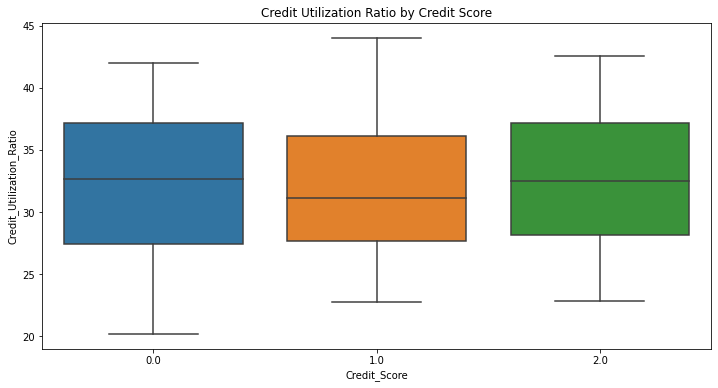

In [ ]:
#Credit Utilization Ratio Distribution
plt.figure(figsize=(12, 6))
sns.boxplot(data=pandas_df, x='Credit_Score', y='Credit_Utilization_Ratio')
plt.title('Credit Utilization Ratio by Credit Score')
plt.show()


## Payment Behaviour Distribution by Credit Score

This horizontal bar plot shows the distribution of payment behavior across different credit score categories:
- **0.0 (Poor)**: Individuals in this group tend to show a wide distribution of payment behaviors, including both low and high payment values.
- **1.0 (Standard)**: A mix of medium to high value payments.
- **2.0 (Good)**: Individuals here exhibit more consistent patterns, especially in the high-value payment categories.

The chart provides insights into how different payment behaviors (e.g., high vs. low spending, small vs. large value payments) are distributed across various credit score groups.


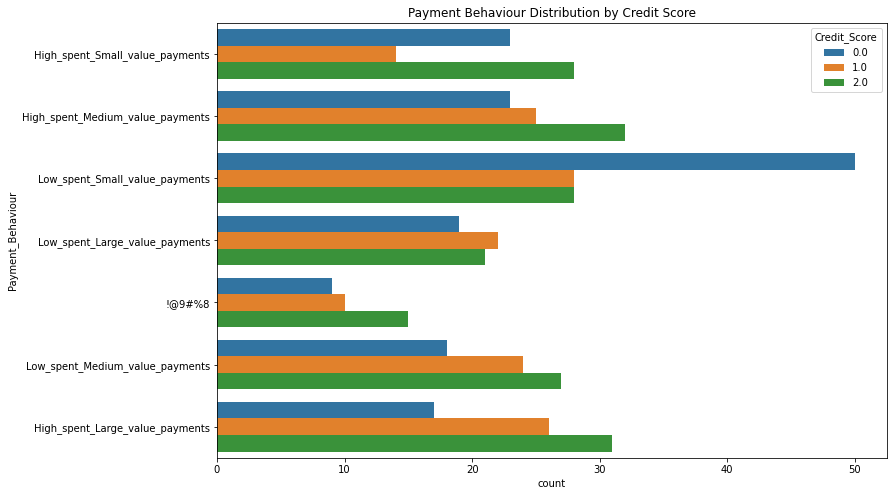

In [ ]:
    plt.figure(figsize=(12, 8))
    sns.countplot(data=pandas_df, y='Payment_Behaviour', hue='Credit_Score')
    plt.title('Payment Behaviour Distribution by Credit Score')
    plt.show()

## Distribution of Credit Scores

This bar plot visualizes the distribution of credit scores across different credit mixes:
- **Good**: The group with the "Good" credit mix shows a relatively balanced distribution across different credit scores, but with fewer individuals compared to the "Standard" category.
- **Standard**: This category dominates the chart with a large number of individuals in the "Standard" credit mix, particularly for the "Standard" credit score.
- **Poor**: A smaller portion of individuals have a "Bad" credit mix, with a notable but lesser number for the "Poor" credit score category.

This chart helps to understand how credit scores are distributed within different credit mixes, indicating trends in creditworthiness.


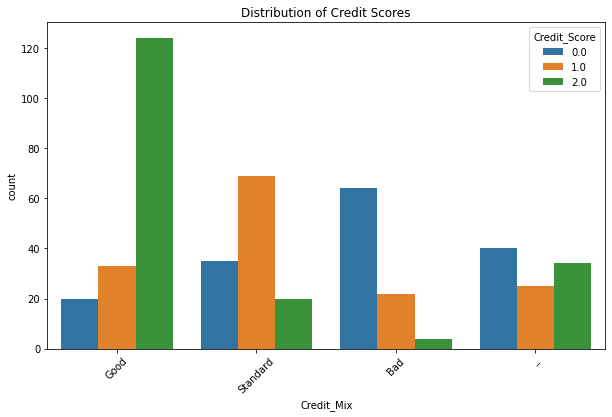

In [ ]:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=pandas_df, x='Credit_Mix',hue="Credit_Score")
    plt.title('Distribution of Credit Scores')
    plt.xticks(rotation=45)
    plt.show()

## Distribution of Credit Scores by Occupation

This bar plot shows the distribution of credit scores across various occupations:
- **Occupations** like Scientist, Lawyer, and Developer show a higher concentration of individuals with good credit scores (2.0), while other occupations like Teacher and Mechanic have a more balanced distribution across credit score categories.
- **Credit Scores**:
  - **0.0 (Poor)**: Occupations like Developer and Writer show fewer individuals with poor credit.
  - **1.0 (Standard)**: Most occupations show a mix of individuals with standard credit scores.
  - **2.0 (Good)**: Occupations like Scientist and Lawyer tend to have a higher number of individuals with good credit scores.

The chart offers insights into how credit scores are distributed across different professions, indicating potential trends in creditworthiness based on occupation.


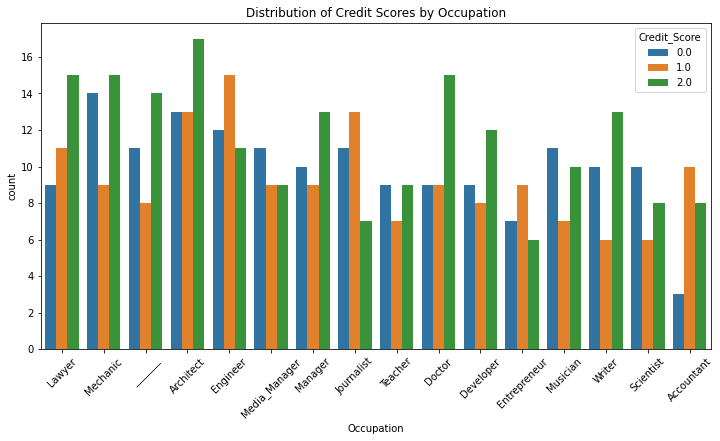

In [ ]:
def plot_credit_score_distribution_by_occupation():
    """Plots a bar graph showing the distribution of credit scores by occupation."""
    plt.figure(figsize=(12, 6))
    sns.countplot(data=pandas_df, x='Occupation', hue='Credit_Score')
    plt.title('Distribution of Credit Scores by Occupation')
    plt.xticks(rotation=45)
    plt.show()

plot_credit_score_distribution_by_occupation()

### Cleaning up the columns

In [ ]:

def replace_value_in_column(df, column_name, old_value, new_value):
  return df.withColumn(column_name, F.when(F.col(column_name) == old_value, new_value).otherwise(F.col(column_name)))

# Example usage:
df = replace_value_in_column(df, 'Payment_Behaviour', '!@9#%8', 'Unknown')
df = replace_value_in_column(df, 'Occupation', '_______', 'Unknown')
df = replace_value_in_column(df, 'Credit_Mix', '_', 'Unknown')


### After Exploratory Data anlysis and Data Cleaning

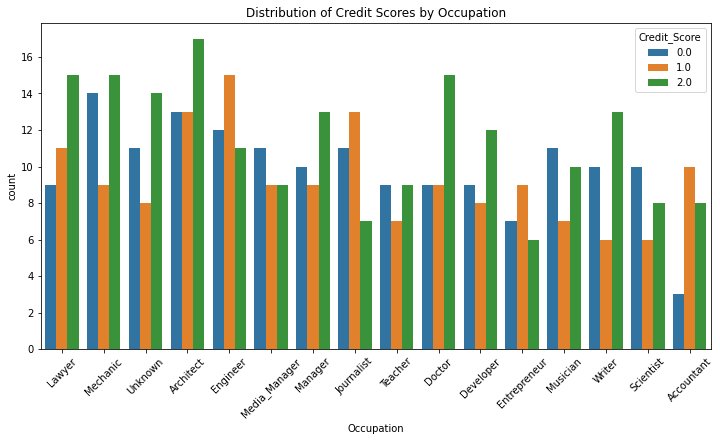

In [ ]:
# Convert a sample of Spark DataFrame to Pandas for visualization
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()

def plot_credit_score_distribution_by_occupation():
    """Plots a bar graph showing the distribution of credit scores by occupation."""
    plt.figure(figsize=(12, 6))
    sns.countplot(data=pandas_df, x='Occupation', hue='Credit_Score')
    plt.title('Distribution of Credit Scores by Occupation')
    plt.xticks(rotation=45)
    plt.show()

plot_credit_score_distribution_by_occupation()

# Feature Engineering

Feature engineering is a critical step to enhance the predictive power of machine learning models. In this process, new features are created through interactions, ratios, and bins. Additionally, outlier handling is applied to improve data quality.

## Key Steps in Feature Engineering

### 1. **Interaction Features**
   - **EMI to Income Ratio**: This feature measures the proportion of monthly EMI payments relative to monthly income.
   - **Debt to Income Ratio**: This ratio represents the relationship between outstanding debt and annual income.
   - **Utilization to Income Ratio**: It calculates the credit utilization ratio relative to the income.
   - **Investment to Income Ratio**: This ratio shows the proportion of monthly investment to monthly income.

### 2. **Ratios and Derived Features**
   - **Delayed Payment Ratio**: This feature shows the proportion of delayed payments relative to the total number of loans.
   - **Credit Card Load**: This metric indicates the number of credit cards as a fraction of annual income.

### 3. **Binned Features**
   - Numeric features like `Annual_Income`, `Credit_Utilization_Ratio`, and `Outstanding_Debt` are binned into categories to create more interpretable features. Binning divides the data into intervals based on quantiles, making the features easier to use in models.

### 4. **Outlier Handling**
   - **Interquartile Range (IQR) Method**: Outliers in numeric columns are identified and handled using the IQR method. Any data points outside the defined range are replaced by the upper or lower bounds, ensuring that the model is not influenced by extreme values.


In [ ]:
# Create interaction features
df = df.withColumn('EMI_to_Income',
                   F.col('Total_EMI_per_month') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')/12).otherwise(1))
df = df.withColumn('Debt_to_Income',
                   F.col('Outstanding_Debt') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')).otherwise(1))
df = df.withColumn('Utilization_to_Income',
                   F.col('Credit_Utilization_Ratio') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')).otherwise(1))
df = df.withColumn('Investment_to_Income',
                   F.col('Amount_invested_monthly') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')/12).otherwise(1))

# Create ratios and derived features
df = df.withColumn('Delayed_Payment_Ratio',
                   F.col('Num_of_Delayed_Payment') / F.when(F.col('Num_of_Loan') > 0, F.col('Num_of_Loan')).otherwise(1))
df = df.withColumn('Credit_Card_Load',
                   F.col('Num_Credit_Card') / F.when(F.col('Annual_Income') > 0, F.col('Annual_Income')/100000).otherwise(1))

# Create bins for numeric features
def create_bins(df, column, num_bins=5):
    quantiles = df.approxQuantile(column, [x/num_bins for x in range(1, num_bins)], 0.01)
    bucketizer = Bucketizer(splits=[float('-inf')] + quantiles + [float('inf')],
                           inputCol=column,
                           outputCol=f"{column}_binned")
    return bucketizer.transform(df)

# Add binned features for key numeric columns
numeric_to_bin = ['Annual_Income', 'Credit_Utilization_Ratio', 'Outstanding_Debt']
for col in numeric_to_bin:
    df = create_bins(df, col)

# Add new features to numeric_columns
new_numeric_features = ['EMI_to_Income', 'Debt_to_Income', 'Utilization_to_Income',
                       'Investment_to_Income', 'Delayed_Payment_Ratio', 'Credit_Card_Load']
numeric_columns.extend(new_numeric_features)

# 2. Improved Data Cleaning
# Handle outliers using IQR method
def handle_outliers(df, column):
    # Calculate Q1, Q3 and IQR
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with bounds
    return df.withColumn(
        column,
        F.when(F.col(column) > upper_bound, upper_bound)
         .when(F.col(column) < lower_bound, lower_bound)
         .otherwise(F.col(column))
    )

# Apply outlier handling to numeric columns
for column in numeric_columns:
    df = handle_outliers(df, column)

## **Class Imbalance Handling**

To address class imbalance in the dataset:
- Class weights are calculated based on the distribution of `Credit_Score` classes. These weights are used to penalize the underrepresented classes during training, ensuring the model treats all classes more equitably.

In [ ]:
# Handle Class Imbalance
# Calculate class weights
class_counts = df.groupBy("Credit_Score").count().collect()
total = df.count()
class_weights = {row['Credit_Score']: total / (len(class_counts) * row['count'])
                for row in class_counts}

##  **Train-Test Split with Stratification**

The dataset is split into training and validation sets using stratified sampling. This ensures that the class distribution is preserved across both sets, making the model evaluation more reliable.

In [ ]:
# Train-Test Split with Stratification
fractions = df.select("Credit_Score").distinct().withColumn(
    "fraction", F.lit(0.8)
).rdd.collectAsMap()

train_data = df.sampleBy("Credit_Score", fractions, seed=42)
val_data = df.subtract(train_data)

# MILESTONE 2

## Credit Score Multi-Model Pipeline Overview

The **Credit Score Multi-Model Pipeline** in PySpark is designed to preprocess data, train machine learning models, and evaluate their performance. Key components include:

- **Data Preprocessing**:
  - Imputation for missing values in numeric features.
  - Standardization of numeric features for normalization.
  - Categorical encoding using `StringIndexer` and `OneHotEncoder`.
  - Feature assembly for combining numeric and categorical features.

- **Model Building**:
  - Implements Random Forest, Logistic Regression, and Gradient Boosting Trees classifiers.
  - Utilizes PySpark's `Pipeline` for streamlined model creation.

- **Hyperparameter Tuning**:
  - Uses `ParamGridBuilder` and cross-validation for parameter optimization.

- **Evaluation**:
  - Computes metrics like accuracy, precision, recall, and F1 score.
  - Visualizes confusion matrices for detailed performance insights.

This pipeline is efficient, scalable, and well-suited for large-scale credit score classification tasks.

For running this code in databricks, we had to reduce the dataset size due to memory contraints.
We also deployed this code to Kubernetes.

Below is a screenshot showing the results of the pySpark ML pipeline deployed on Kubernetes. Additionally, all codes and files have been shared on iCollege as part of the project submission. Here are the screenshots:
[Cluster Details](https://drive.google.com/file/d/1FJIFTrzJjtQ6IPy_LB5fnyBoEQcuWUH4/view?usp=sharing)
and [Pipeline execution on Kubernetes](https://drive.google.com/file/d/1KZ8Qko37gRFNsuA-I8p4Zb_NVdK0GKm4/view?usp=sharing)




Training RandomForest...

RandomForest Performance Metrics:
Accuracy: 0.7067
Weighted Precision: 0.7069
Weighted Recall: 0.7067
F1 Score: 0.7007

Confusion Matrix:
+------------+----------+-----+
|Credit_Score|prediction|count|
+------------+----------+-----+
|         0.0|       0.0|  259|
|         0.0|       1.0|   36|
|         0.0|       2.0|   51|
|         1.0|       0.0|   83|
|         1.0|       1.0|  173|
|         1.0|       2.0|   71|
|         2.0|       0.0|    3|
|         2.0|       1.0|   44|
|         2.0|       2.0|  262|
+------------+----------+-----+



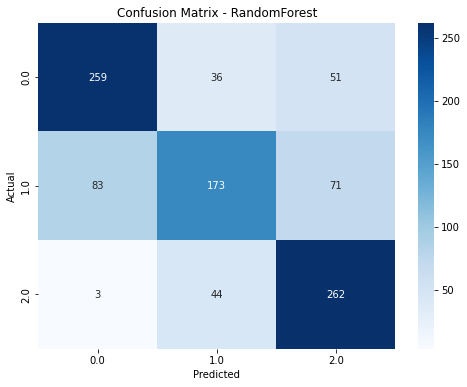


Training LogisticRegression...

LogisticRegression Performance Metrics:
Accuracy: 0.6884
Weighted Precision: 0.6871
Weighted Recall: 0.6884
F1 Score: 0.6834

Confusion Matrix:
+------------+----------+-----+
|Credit_Score|prediction|count|
+------------+----------+-----+
|         0.0|       0.0|  244|
|         0.0|       1.0|   54|
|         0.0|       2.0|   48|
|         1.0|       0.0|   80|
|         1.0|       1.0|  173|
|         1.0|       2.0|   74|
|         2.0|       0.0|    3|
|         2.0|       1.0|   47|
|         2.0|       2.0|  259|
+------------+----------+-----+



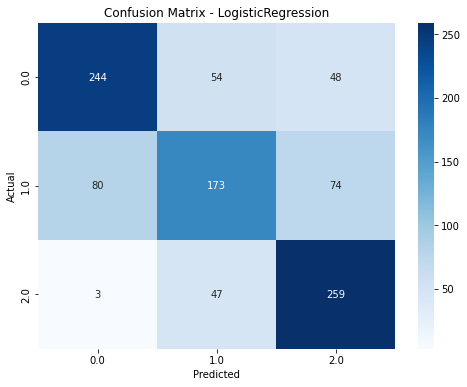


Training GradientBoosting...

GradientBoosting Performance Metrics:
Accuracy: 0.6965
Weighted Precision: 0.6987
Weighted Recall: 0.6965
F1 Score: 0.6874

Confusion Matrix:
+------------+----------+-----+
|Credit_Score|prediction|count|
+------------+----------+-----+
|         0.0|       0.0|  259|
|         0.0|       1.0|   36|
|         0.0|       2.0|   51|
|         1.0|       0.0|   85|
|         1.0|       1.0|  158|
|         1.0|       2.0|   84|
|         2.0|       0.0|    7|
|         2.0|       1.0|   35|
|         2.0|       2.0|  267|
+------------+----------+-----+



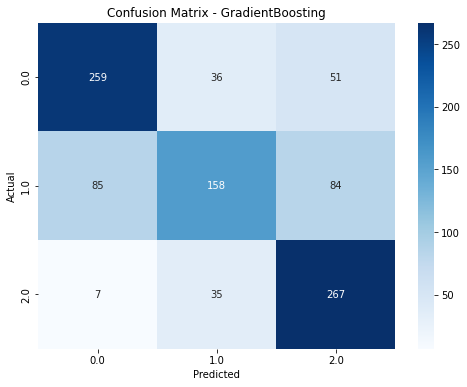


Best performing model: RandomForest
Best model metrics:
Accuracy: 0.7067
Weighted Precision: 0.7069
Weighted Recall: 0.7067
F1 Score: 0.7007


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    RandomForestClassifier,
    LogisticRegression,
    GBTClassifier,
    OneVsRest
)
from pyspark.ml.feature import (
    Imputer,
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler,
    Bucketizer
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class CreditScoreMultiModelPipeline:
    def __init__(self, train_data, val_data, numeric_columns, categorical_columns):
        """
        Initialize pipeline with data and column specifications
        """
        self.train_data = train_data
        self.val_data = val_data
        self.numeric_columns = numeric_columns
        self.categorical_columns = categorical_columns
        self.base_pipeline_stages = self._create_base_pipeline_stages()

    def _create_base_pipeline_stages(self):
        """Create all preprocessing and feature engineering stages"""

        # 1. Imputer for numeric columns
        imputer = Imputer(
            inputCols=self.numeric_columns,
            outputCols=[f"{col}_imputed" for col in self.numeric_columns],
            strategy="mean"
        )

        # 2. Numeric feature assembler
        numeric_assembler = VectorAssembler(
            inputCols=[f"{col}_imputed" for col in self.numeric_columns],
            outputCol="numeric_features",
            handleInvalid="keep"
        )

        # 3. Standard scaler for numeric features
        standard_scaler = StandardScaler(
            inputCol="numeric_features",
            outputCol="scaled_numeric_features",
            withStd=True,
            withMean=True
        )

        # 4. Categorical feature processing
        indexers = [StringIndexer(inputCol=col,
                                outputCol=f"{col}_indexed",
                                handleInvalid="keep")
                   for col in self.categorical_columns]

        encoders = [OneHotEncoder(inputCol=f"{col}_indexed",
                                outputCol=f"{col}_encoded",
                                handleInvalid="keep")
                   for col in self.categorical_columns]

        # 5. Final feature assembler
        final_assembler = VectorAssembler(
            inputCols=["scaled_numeric_features"] +
                     [f"{col}_encoded" for col in self.categorical_columns],
            outputCol="features",
            handleInvalid="keep"
        )

        return [imputer] + [numeric_assembler] + [standard_scaler] + indexers + encoders + [final_assembler]

    def create_model_pipelines(self):
        """Create all model pipelines with their parameter grids"""

        # 1. Random Forest Pipeline
        rf = RandomForestClassifier(
            labelCol="Credit_Score",
            featuresCol="features",
            numTrees=100,
            seed=42
        )
        rf_pipeline = Pipeline(stages=self.base_pipeline_stages + [rf])
        rf_paramGrid = ParamGridBuilder() \
            .addGrid(rf.maxDepth, [3]) \
            .addGrid(rf.minInstancesPerNode, [1, 2]) \
            .build()

        # 2. Logistic Regression Pipeline
        lr = LogisticRegression(
            labelCol="Credit_Score",
            featuresCol="features",
            maxIter=100,
            family="multinomial",
            standardization=False,
            elasticNetParam=0.5
        )
        lr_pipeline = Pipeline(stages=self.base_pipeline_stages + [lr])
        lr_paramGrid = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.1]) \
            .addGrid(lr.elasticNetParam, [0.0]) \
            .addGrid(lr.maxIter, [100]) \
            .build()

        # 3. Gradient Boosting Trees Pipeline
        gbt = GBTClassifier(
            featuresCol="features",
            labelCol="Credit_Score",
            maxIter=10,
            maxDepth=3,
            stepSize=0.05,
            seed=42
        )
        ovr_gbt = OneVsRest(
            classifier=gbt,
            labelCol="Credit_Score",
            featuresCol="features"
        )
        gbt_pipeline = Pipeline(stages=self.base_pipeline_stages + [ovr_gbt])
        gbt_paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [3]) \
            .addGrid(gbt.stepSize, [0.05]) \
            .build()

        return {
            'RandomForest': {
                'pipeline': rf_pipeline,
                'paramGrid': rf_paramGrid,
                'model': rf
            },
            'LogisticRegression': {
                'pipeline': lr_pipeline,
                'paramGrid': lr_paramGrid,
                'model': lr
            },
            'GradientBoosting': {
                'pipeline': gbt_pipeline,
                'paramGrid': gbt_paramGrid,
                'model': ovr_gbt
            }
        }

    def train_and_evaluate(self):
        """Train and evaluate all models"""

        model_configs = self.create_model_pipelines()
        results = {}

        evaluator = MulticlassClassificationEvaluator(
            labelCol="Credit_Score",
            predictionCol="prediction"
        )

        for model_name, config in model_configs.items():
            print(f"\nTraining {model_name}...")

            # Create cross validator
            cv = CrossValidator(
                estimator=config['pipeline'],
                estimatorParamMaps=config['paramGrid'],
                evaluator=evaluator.setMetricName("accuracy"),
                numFolds=3,
                seed=42
            )

            # Train model
            model = cv.fit(self.train_data)
            predictions = model.transform(self.val_data)

            # Calculate metrics
            metrics = {
                'Accuracy': evaluator.setMetricName("accuracy").evaluate(predictions),
                'Weighted Precision': evaluator.setMetricName("weightedPrecision").evaluate(predictions),
                'Weighted Recall': evaluator.setMetricName("weightedRecall").evaluate(predictions),
                'F1 Score': evaluator.setMetricName("f1").evaluate(predictions)
            }

            # Generate confusion matrix
            confusion_matrix = predictions.groupBy("Credit_Score", "prediction") \
                .count() \
                .orderBy("Credit_Score", "prediction")

            # Store results
            results[model_name] = {
                'model': model,
                'predictions': predictions,
                'metrics': metrics,
                'confusion_matrix': confusion_matrix
            }

            # Print results
            print(f"\n{model_name} Performance Metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
            print("\nConfusion Matrix:")
            confusion_matrix.show()

            # Visualize confusion matrix
            self._plot_confusion_matrix(confusion_matrix, model_name)

        return results

    def _plot_confusion_matrix(self, confusion_matrix, model_name):
        """Plot confusion matrix for a model"""
        conf_matrix_pd = confusion_matrix.toPandas()
        conf_matrix_pivot = conf_matrix_pd.pivot(
            index="Credit_Score",
            columns="prediction",
            values="count"
        ).fillna(0)

        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix_pivot, annot=True, fmt='.0f', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Usage
def main():
    # Initialize pipeline
    pipeline = CreditScoreMultiModelPipeline(
        train_data=train_data,
        val_data=val_data,
        numeric_columns=numeric_columns,
        categorical_columns=categorical_columns
    )

    # Train and evaluate all models
    results = pipeline.train_and_evaluate()

    # Find best model
    best_model_name = max(results.items(),
                         key=lambda x: x[1]['metrics']['Accuracy'])[0]

    print(f"\nBest performing model: {best_model_name}")
    print("Best model metrics:")
    for metric, value in results[best_model_name]['metrics'].items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()

## Model Performance Summary

Three models—Random Forest, Logistic Regression, and Gradient Boosting—were trained and evaluated for their performance on the dataset. Below are the key results:

- **Random Forest** emerged as the best-performing model with an accuracy of **70.67%**. It also achieved the highest weighted precision, recall, and F1 score among the three models.
- **Logistic Regression** demonstrated the lowest performance, with an accuracy of **68.84%** and an F1 score of **68.34%**.
- **Gradient Boosting** performed slightly better than Logistic Regression but fell short of Random Forest, with an accuracy of **69.65%** and an F1 score of **68.74%**.

## Brief summary

| Model                 | Accuracy | Weighted Precision | Weighted Recall | F1 Score |
|-----------------------|----------|---------------------|-----------------|----------|
| **Random Forest**     | 70.67%   | 70.69%             | 70.67%         | 70.07%   |
| **Logistic Regression**   | 68.84%   | 68.71%             | 68.84%         | 68.34%   |
| **Gradient Boosting**     | 69.65%   | 69.87%             | 69.65%         | 68.74%   |

## Best Performing Model: Random Forest
- **Accuracy**: 70.67%
- **Weighted Precision**: 70.69%
- **Weighted Recall**: 70.67%
- **F1 Score**: 70.07%




Training RandomForest...

RandomForest Performance Metrics:
Accuracy: 0.7067
Weighted Precision: 0.7069
Weighted Recall: 0.7067
F1 Score: 0.7007

Training LogisticRegression...

LogisticRegression Performance Metrics:
Accuracy: 0.6884
Weighted Precision: 0.6871
Weighted Recall: 0.6884
F1 Score: 0.6834

Training GradientBoosting...

GradientBoosting Performance Metrics:
Accuracy: 0.6965
Weighted Precision: 0.6987
Weighted Recall: 0.6965
F1 Score: 0.6874


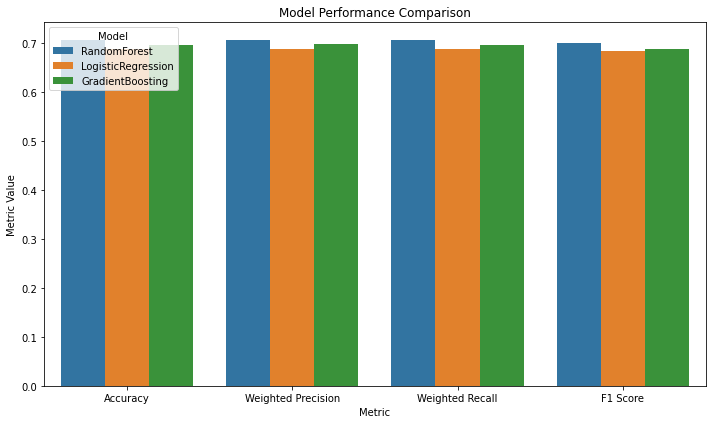


Best performing model: RandomForest
Best model metrics:
Accuracy: 0.7067
Weighted Precision: 0.7069
Weighted Recall: 0.7067
F1 Score: 0.7007


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    RandomForestClassifier,
    LogisticRegression,
    GBTClassifier,
    OneVsRest
)
from pyspark.ml.feature import (
    Imputer,
    StringIndexer,
    OneHotEncoder,
    VectorAssembler,
    StandardScaler
)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class CreditScoreMultiModelPipeline:
    def __init__(self, train_data, val_data, numeric_columns, categorical_columns):
        """
        Initialize pipeline with data and column specifications
        """
        self.train_data = train_data
        self.val_data = val_data
        self.numeric_columns = numeric_columns
        self.categorical_columns = categorical_columns
        self.base_pipeline_stages = self._create_base_pipeline_stages()

    def _create_base_pipeline_stages(self):
        """Create all preprocessing and feature engineering stages"""

        # 1. Imputer for numeric columns
        imputer = Imputer(
            inputCols=self.numeric_columns,
            outputCols=[f"{col}_imputed" for col in self.numeric_columns],
            strategy="mean"
        )

        # 2. Numeric feature assembler
        numeric_assembler = VectorAssembler(
            inputCols=[f"{col}_imputed" for col in self.numeric_columns],
            outputCol="numeric_features",
            handleInvalid="keep"
        )

        # 3. Standard scaler for numeric features
        standard_scaler = StandardScaler(
            inputCol="numeric_features",
            outputCol="scaled_numeric_features",
            withStd=True,
            withMean=True
        )

        # 4. Categorical feature processing
        indexers = [StringIndexer(inputCol=col,
                                outputCol=f"{col}_indexed",
                                handleInvalid="keep")
                   for col in self.categorical_columns]

        encoders = [OneHotEncoder(inputCol=f"{col}_indexed",
                                outputCol=f"{col}_encoded",
                                handleInvalid="keep")
                   for col in self.categorical_columns]

        # 5. Final feature assembler
        final_assembler = VectorAssembler(
            inputCols=["scaled_numeric_features"] +
                     [f"{col}_encoded" for col in self.categorical_columns],
            outputCol="features",
            handleInvalid="keep"
        )

        return [imputer] + [numeric_assembler] + [standard_scaler] + indexers + encoders + [final_assembler]

    def create_model_pipelines(self):
        """Create all model pipelines with their parameter grids"""

        # 1. Random Forest Pipeline
        rf = RandomForestClassifier(
            labelCol="Credit_Score",
            featuresCol="features",
            numTrees=100,
            seed=42
        )
        rf_pipeline = Pipeline(stages=self.base_pipeline_stages + [rf])
        rf_paramGrid = ParamGridBuilder() \
            .addGrid(rf.maxDepth, [3]) \
            .addGrid(rf.minInstancesPerNode, [1, 2]) \
            .build()

        # 2. Logistic Regression Pipeline
        lr = LogisticRegression(
            labelCol="Credit_Score",
            featuresCol="features",
            maxIter=100,
            family="multinomial",
            standardization=False,
            elasticNetParam=0.5
        )
        lr_pipeline = Pipeline(stages=self.base_pipeline_stages + [lr])
        lr_paramGrid = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.1]) \
            .addGrid(lr.elasticNetParam, [0.0]) \
            .addGrid(lr.maxIter, [100]) \
            .build()

        # 3. Gradient Boosting Trees Pipeline
        gbt = GBTClassifier(
            featuresCol="features",
            labelCol="Credit_Score",
            maxIter=10,
            maxDepth=3,
            stepSize=0.05,
            seed=42
        )
        ovr_gbt = OneVsRest(
            classifier=gbt,
            labelCol="Credit_Score",
            featuresCol="features"
        )
        gbt_pipeline = Pipeline(stages=self.base_pipeline_stages + [ovr_gbt])
        gbt_paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [3]) \
            .addGrid(gbt.stepSize, [0.05]) \
            .build()

        return {
            'RandomForest': {
                'pipeline': rf_pipeline,
                'paramGrid': rf_paramGrid,
                'model': rf
            },
            'LogisticRegression': {
                'pipeline': lr_pipeline,
                'paramGrid': lr_paramGrid,
                'model': lr
            },
            'GradientBoosting': {
                'pipeline': gbt_pipeline,
                'paramGrid': gbt_paramGrid,
                'model': ovr_gbt
            }
        }

    def train_and_evaluate(self):
        """Train and evaluate all models"""

        model_configs = self.create_model_pipelines()
        results = {}

        evaluator = MulticlassClassificationEvaluator(
            labelCol="Credit_Score",
            predictionCol="prediction"
        )

        for model_name, config in model_configs.items():
            print(f"\nTraining {model_name}...")

            # Create cross validator
            cv = CrossValidator(
                estimator=config['pipeline'],
                estimatorParamMaps=config['paramGrid'],
                evaluator=evaluator.setMetricName("accuracy"),
                numFolds=3,
                seed=42
            )

            # Train model
            model = cv.fit(self.train_data)
            predictions = model.transform(self.val_data)

            # Calculate metrics
            metrics = {
                'Accuracy': evaluator.setMetricName("accuracy").evaluate(predictions),
                'Weighted Precision': evaluator.setMetricName("weightedPrecision").evaluate(predictions),
                'Weighted Recall': evaluator.setMetricName("weightedRecall").evaluate(predictions),
                'F1 Score': evaluator.setMetricName("f1").evaluate(predictions)
            }

            # Store results
            results[model_name] = {
                'model': model,
                'metrics': metrics
            }

            # Print results
            print(f"\n{model_name} Performance Metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")

        self._plot_model_comparison(results)
        return results

    def _plot_model_comparison(self, results):
        """Plot comparison of all models"""
        metrics_data = []

        for model_name, data in results.items():
            for metric, value in data['metrics'].items():
                metrics_data.append({
                    'Model': model_name,
                    'Metric': metric,
                    'Value': value
                })

        metrics_df = pd.DataFrame(metrics_data)

        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=metrics_df,
            x='Metric',
            y='Value',
            hue='Model'
        )
        plt.title('Model Performance Comparison')
        plt.ylabel('Metric Value')
        plt.xlabel('Metric')
        plt.legend(title='Model', loc='upper left')
        plt.tight_layout()
        plt.show()

# Usage
def main():
    # Initialize pipeline
    pipeline = CreditScoreMultiModelPipeline(
        train_data=train_data,
        val_data=val_data,
        numeric_columns=numeric_columns,
        categorical_columns=categorical_columns
    )

    # Train and evaluate all models
    results = pipeline.train_and_evaluate()

    # Find best model
    best_model_name = max(results.items(),
                         key=lambda x: x[1]['metrics']['Accuracy'])[0]

    print(f"\nBest performing model: {best_model_name}")
    print("Best model metrics:")
    for metric, value in results[best_model_name]['metrics'].items():
        print(f"{metric}: {value:.4f}")

if __name__ == "__main__":
    main()
